In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
train_path = '../input/titanic/train.csv'
test_path = '../input/titanic/test.csv'
# load train and test data using pandas
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [3]:
print(train_data.head(7))

print(train_data.dtypes)

print(train_data.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN

# 2 Pre-Processing

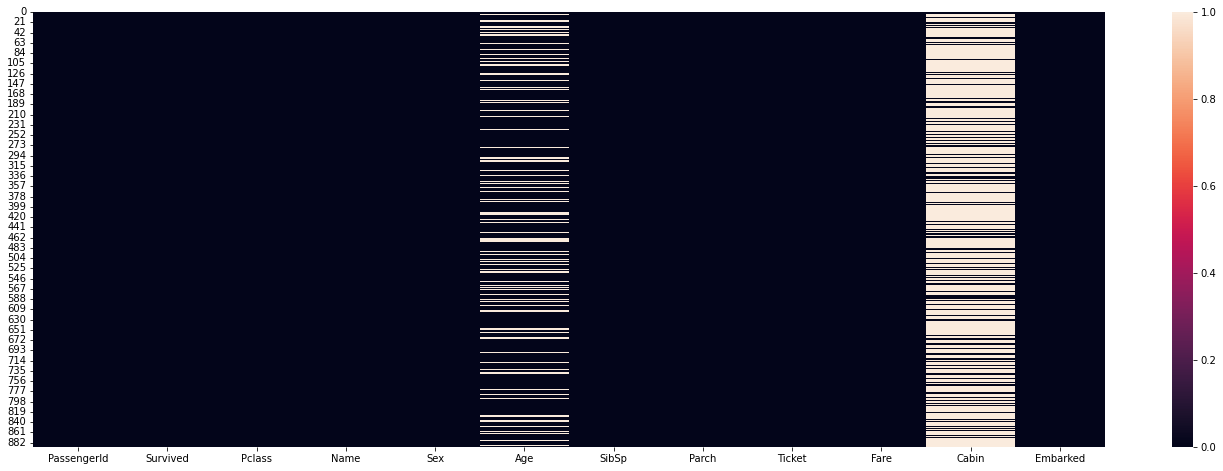

In [4]:
plt.figure(figsize=(24,8))
sns.heatmap(train_data.isnull())
plt.show()

## 2.1 Feature Engineering and EDA

**train_data['Pclass']**

In [5]:
# Pclass represents the socio economic status of the passengers. Does person having higher socio economic status have higher survival rate than person with lower economic status?

# print(train_data['Pclass'].unique())
train_data['Pclass_1'] = train_data['Pclass'].replace({1:1, 2:0, 3:0})
train_data['Pclass_2'] = train_data['Pclass'].replace({1:0, 2:1, 3:0})
train_data['Pclass_3'] = train_data['Pclass'].replace({1:0, 2:0, 3:1})

print(train_data.head(7))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   

   Parch            Ticket     Fare Cabin Embarked  Pclass_1  Pclass_2  \
0      0         A/5

In [6]:
print(train_data['Pclass_1'].groupby(train_data['Survived']).sum()) # 62% Survived
print(train_data['Pclass_2'].groupby(train_data['Survived']).sum()) # 45% Survived
print(train_data['Pclass_3'].groupby(train_data['Survived']).sum()) # 24% Survived

Survived
0     80
1    136
Name: Pclass_1, dtype: int64
Survived
0    97
1    87
Name: Pclass_2, dtype: int64
Survived
0    372
1    119
Name: Pclass_3, dtype: int64


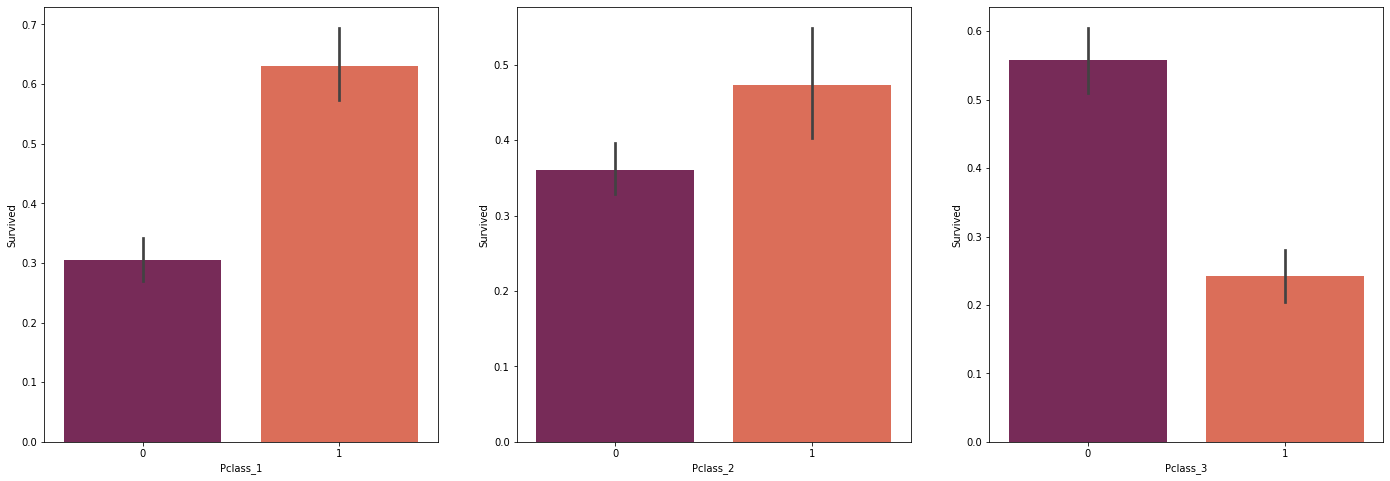

In [7]:
f,(a1,a2,a3) = plt.subplots(1,3, figsize=(24,8),sharex=True)
sns.barplot(x='Pclass_1',y='Survived',data=train_data,palette="rocket",ax=a1)
sns.barplot(x='Pclass_2',y='Survived',data=train_data,palette="rocket",ax=a2)
sns.barplot(x='Pclass_3',y='Survived',data=train_data,palette="rocket",ax=a3)
plt.show()

**train_data['Name']**

In [8]:
# print(train_data['Name'].head(10))
train_data['Title']= train_data.Name.apply(lambda x:x[x.find(','):x.find('.')][1:].strip())
# print(train_data['Title'].unique())
title_list = ['Mr','Mrs','Miss','Ms','Mlle','Lady','Sir','Master']
train_data['Title'] = train_data['Title'].apply(lambda x: 'Mr' if x =='Mr' or x=='Sir' else x)
train_data['Title'] = train_data['Title'].apply(lambda x: 'Mrs' if x =='Mrs' else x)
train_data['Title'] = train_data['Title'].apply(lambda x: 'Miss' if x =='Miss' or x =='Ms' or x=='Mlle' or x=='Lady' else x)
train_data['Title'] = train_data['Title'].apply(lambda x: 'Master' if x =='Master' else x)
train_data['Title'] = train_data['Title'].apply(lambda x: 'Others' if x not in title_list else x)
# print(train_data.head(10))
print(train_data['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Others']


In [9]:
train_data['Mr'] = (train_data['Title'] == 'Mr').replace(False,0).replace(True,1)
train_data['Mrs'] = (train_data['Title'] == 'Mrs').replace(False,0).replace(True,1)
train_data['Miss'] = (train_data['Title'] == 'Miss').replace(False,0).replace(True,1)
train_data['Others'] = (train_data['Title'] == 'Others').replace(False,0).replace(True,1)
train_data['Master'] = (train_data['Title'] == 'Master').replace(False,0).replace(True,1)
# print(train_data.head(10))

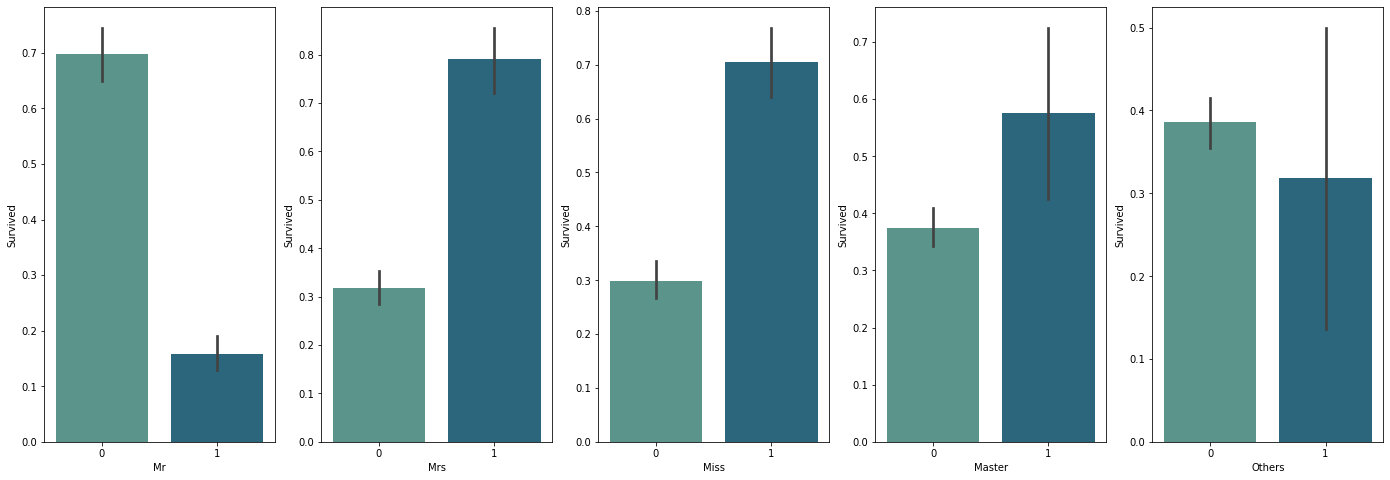

In [10]:
f,(a1,a2,a3,a4,a5) = plt.subplots(1,5,figsize=(24,8), sharex=True)
sns.barplot(x='Mr',y='Survived',data=train_data,palette='crest',ax=a1)
sns.barplot(x='Mrs',y='Survived',data=train_data,palette='crest',ax=a2)
sns.barplot(x='Miss',y='Survived',data=train_data,palette='crest',ax=a3)
sns.barplot(x='Master',y='Survived',data=train_data,palette='crest',ax=a4)
sns.barplot(x='Others',y='Survived',data=train_data,palette='crest',ax=a5)
plt.show()

****train_data['Sex']****

In [11]:
# Check the survival rate for male and females? Do female have a survival rate higher than men?
train_data['Male'] = train_data['Sex'].replace({'male':1,'female':0})
train_data['Female'] = train_data['Sex'].replace({'male': 0,'female': 1})
print(train_data.head(7))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   

   Parch            Ticket     Fare  ... Pclass_2 Pclass_3  Title  Mr  Mrs  \
0      0        

In [12]:
print(train_data['Male'].groupby(train_data['Survived']).sum()) #  20% survived

print(train_data['Female'].groupby(train_data['Survived']).sum()) # 75% survived,

Survived
0    468
1    109
Name: Male, dtype: int64
Survived
0     81
1    233
Name: Female, dtype: int64


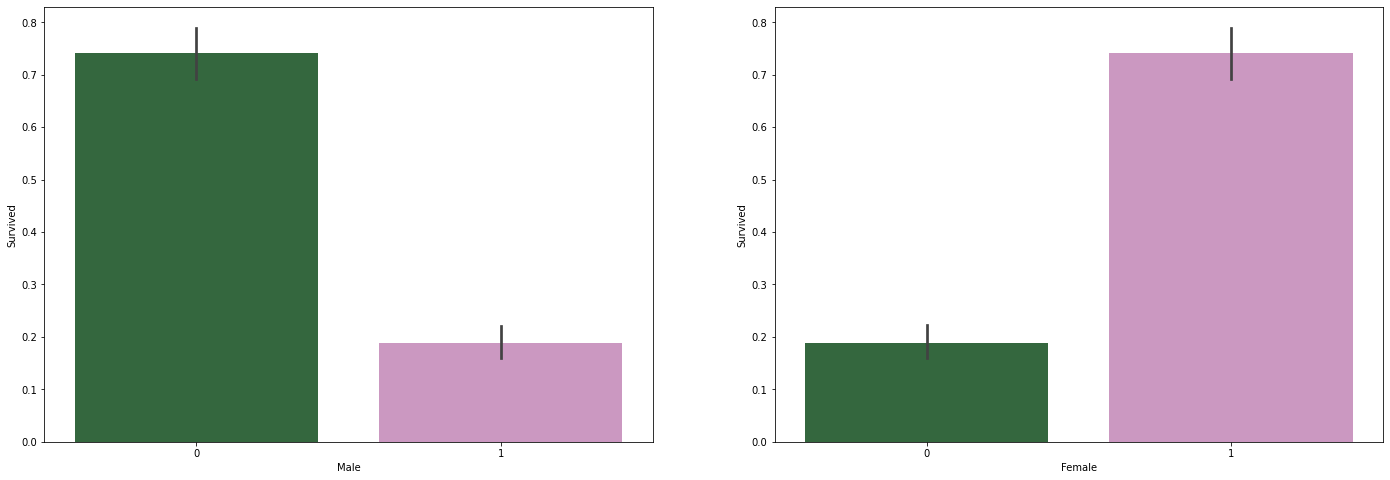

In [13]:
fig, (a1, a2) = plt.subplots(1,2, figsize=(24,8), sharex=True)

sns.barplot(x='Male',y='Survived',data=train_data,palette="cubehelix", ax=a1)
sns.barplot(x='Female', y='Survived', data=train_data,palette="cubehelix", ax= a2)
plt.show()

**train_data['Age']**

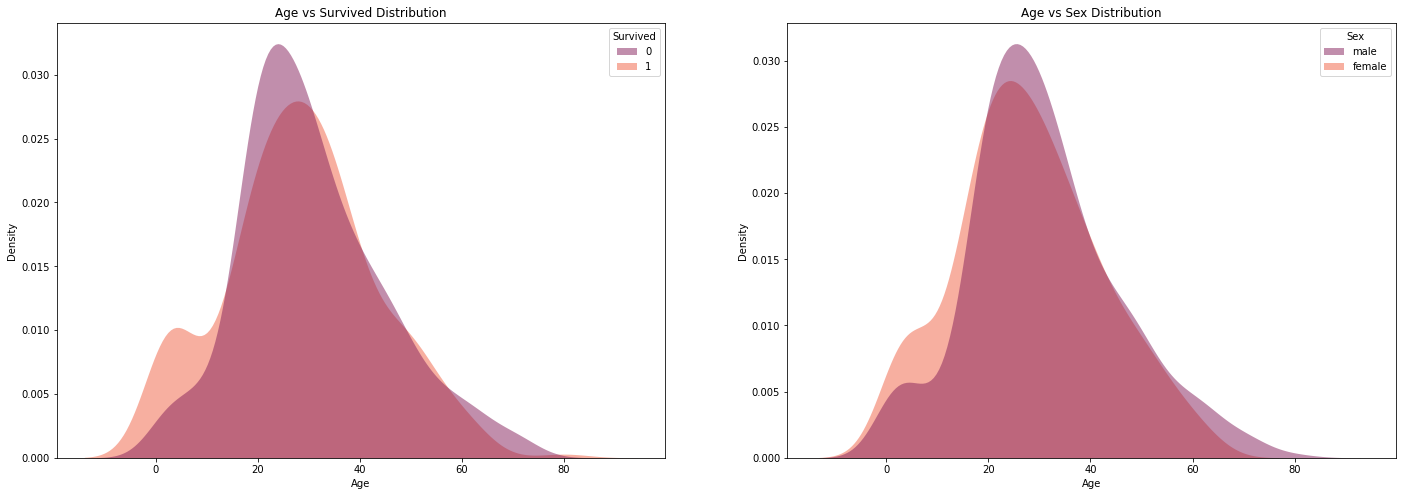

In [14]:
# Age has missing values,we can fill the missing values

# Distribution of values before inserting missing values

f,(a1,a2) = plt.subplots(1,2,figsize=(24,8),sharex=True)
a1.set_title('Age vs Survived Distribution')
sns.kdeplot(data=train_data,x='Age',hue='Survived',ax=a1,fill=True,common_norm=False,palette='rocket',linewidth=0,alpha=0.5)
a2.set_title('Age vs Sex Distribution')
sns.kdeplot(data=train_data,x='Age',hue='Sex',ax=a2,fill=True,common_norm=False,palette='rocket',linewidth=0,alpha=0.5)
plt.show()

In [15]:
# fill the missing age values based on the median of particular class
missing_age_values = train_data.groupby('Pclass').median()['Age']
# print(missing_age_values)

train_data.loc[(train_data['Age'].isnull() == 1) & (train_data['Pclass'] == 1),'Age'] = missing_age_values[1]
train_data.loc[(train_data['Age'].isnull() == 1) & (train_data['Pclass'] == 2),'Age'] = missing_age_values[2]
train_data.loc[(train_data['Age'].isnull() == 1) & (train_data['Pclass'] == 3),'Age'] = missing_age_values[3]

# print(train_data.Age.isnull())

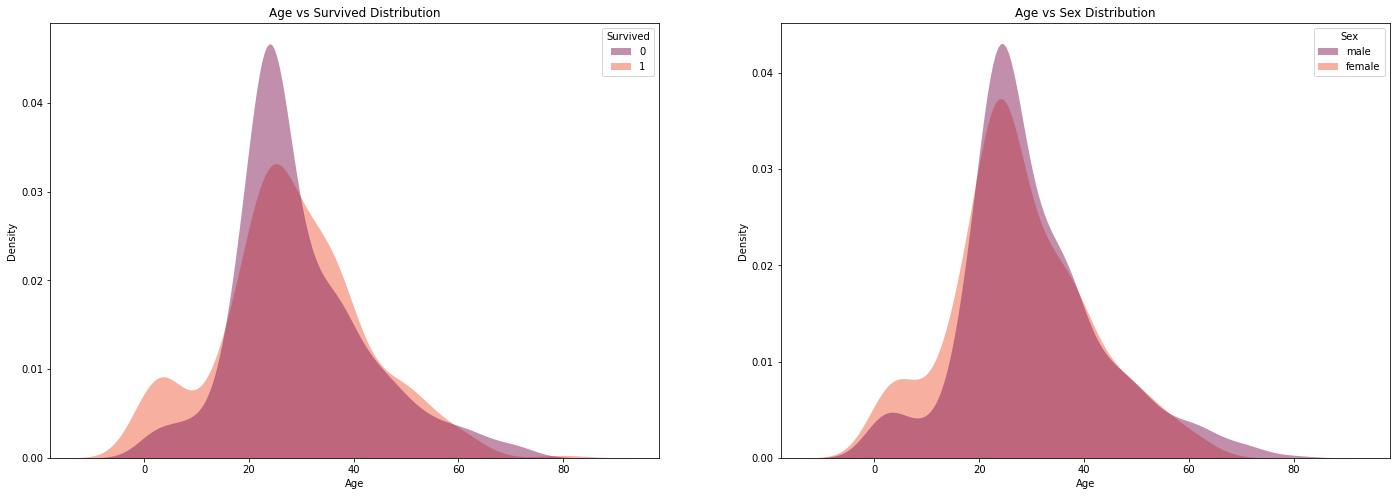

In [16]:
# Distribution after filling missing values
f,(a1,a2) = plt.subplots(1,2,figsize=(24,8),sharex=True)
a1.set_title('Age vs Survived Distribution')
sns.kdeplot(data=train_data,x='Age',hue='Survived',ax=a1,fill=True,common_norm=False,palette='rocket',linewidth=0,alpha=0.5)
a2.set_title('Age vs Sex Distribution')
sns.kdeplot(data=train_data,x='Age',hue='Sex',ax=a2,fill=True,common_norm=False,palette='rocket',linewidth=0,alpha=0.5)
plt.show()

In [17]:
train_data['Age_Senior'] = (train_data['Age']>=60).replace(False,0).replace(True,1)
train_data['Age_LtAdult'] = ((train_data['Age'] >= 45) & (train_data['Age']<60)).replace(False,0).replace(True,1)
train_data['Age_YgAdult'] = ((train_data['Age'] >= 30) & (train_data['Age']<45)).replace(False,0).replace(True,1)
train_data['Age_Teen'] = ((train_data['Age']> 15) & (train_data['Age'] <30)).replace(False,0).replace(True,1)
train_data['Age_Child'] = (train_data['Age'] <=15).replace(False,0).replace(True,1)

# print(train_data.head(10))

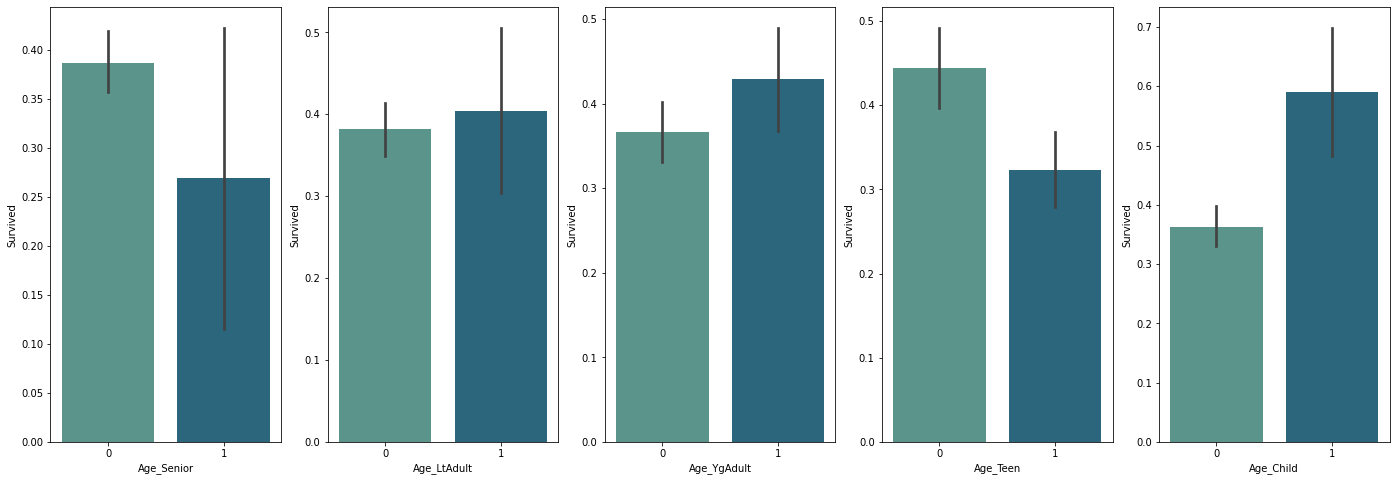

In [18]:
f,(a1,a2,a3,a4,a5) = plt.subplots(1,5,figsize=(24,8), sharex=True)
sns.barplot(x='Age_Senior',y='Survived',data=train_data,palette='crest',ax=a1)
sns.barplot(x='Age_LtAdult',y='Survived',data=train_data,palette='crest',ax=a2)
sns.barplot(x='Age_YgAdult',y='Survived',data=train_data,palette='crest',ax=a3)
sns.barplot(x='Age_Teen',y='Survived',data=train_data,palette='crest',ax=a4)
sns.barplot(x='Age_Child',y='Survived',data=train_data,palette='crest',ax=a5)
plt.show()

**train_data['SibSp']+train_data['Parch']**

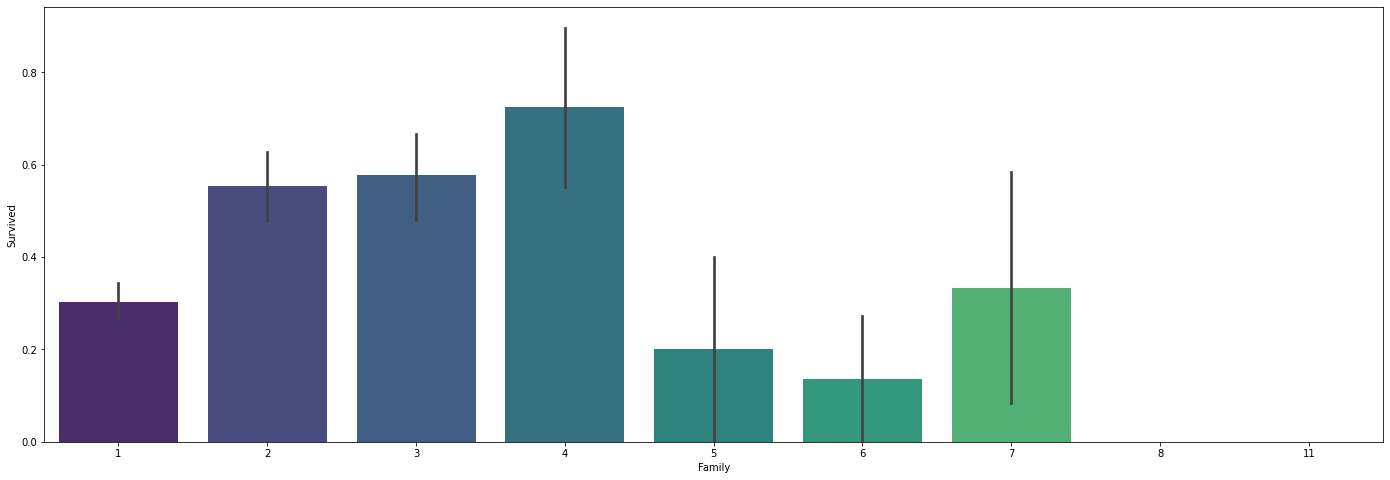

In [19]:
train_data['Family'] = train_data['SibSp'] + train_data['Parch'] + 1
# print(train_data[['SibSp','Parch','Family']])

plt.figure(figsize=(24,8))
sns.barplot(x='Family',y='Survived',data=train_data, palette='viridis')
plt.show()

**train_data['Fare']**

In [20]:
print(train_data['Fare'].describe())

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


In [21]:
# Spliting Fare in differents %
# People who paid 75%+ Fare has high rates to survive if compared with 25%

train_data['Fare_25%'] = (train_data['Fare']<=8).replace(False,0).replace(True,1)
train_data['Fare_50%'] = ((train_data['Fare']>8)&(train_data['Fare']<=15)).replace(False,0).replace(True,1)
train_data['Fare_75%'] = ((train_data['Fare']>15)&(train_data['Fare']<=31)).replace(False,0).replace(True,1)
train_data['Fare_75%+'] = (train_data['Fare']>31).replace(False,0).replace(True,1)

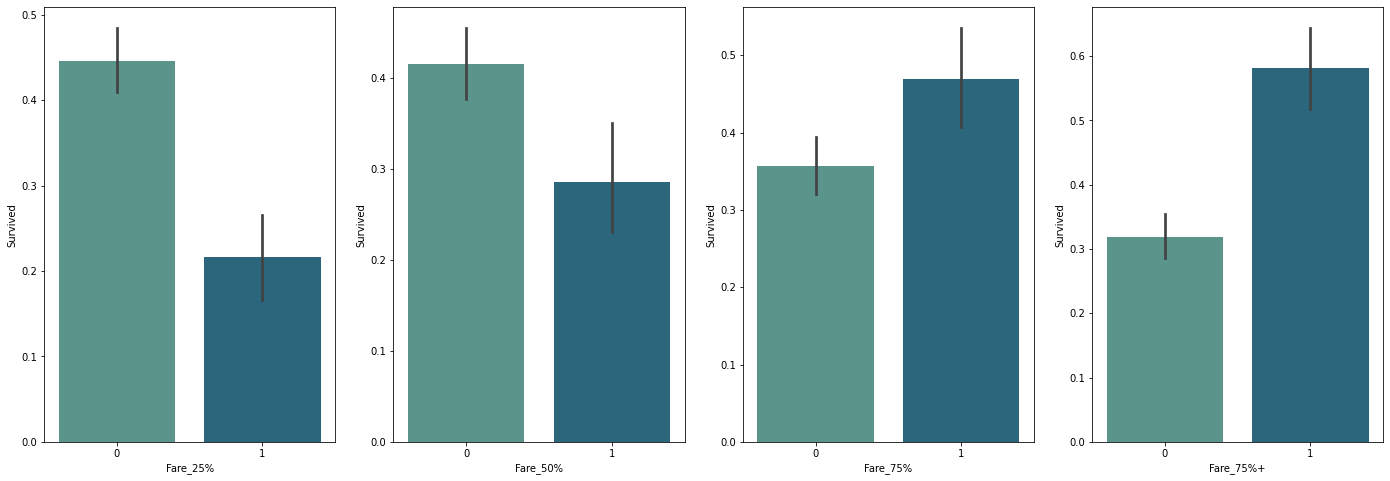

In [22]:
f, (a1,a2,a3,a4) = plt.subplots(1,4,figsize=(24,8),sharex=True)
sns.barplot(x='Fare_25%',y='Survived',data=train_data,palette="crest",ax=a1)
sns.barplot(x='Fare_50%',y='Survived',data=train_data,palette="crest",ax=a2)
sns.barplot(x='Fare_75%',y='Survived',data=train_data,palette="crest",ax=a3)
sns.barplot(x='Fare_75%+',y='Survived',data=train_data,palette="crest",ax=a4)
plt.show()

**train_data['Cabin']**

In [23]:
train_data['Cabin_new']=train_data['Cabin'].astype(str).str[0]
train_data['Cabin_new'] = train_data['Cabin_new'].replace('n','N/A')
print(train_data.head(7))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male  24.0      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   

   Parch            Ticket     Fare  ... Age_LtAdult Age_YgAdult  Age_Teen  \
0      0        

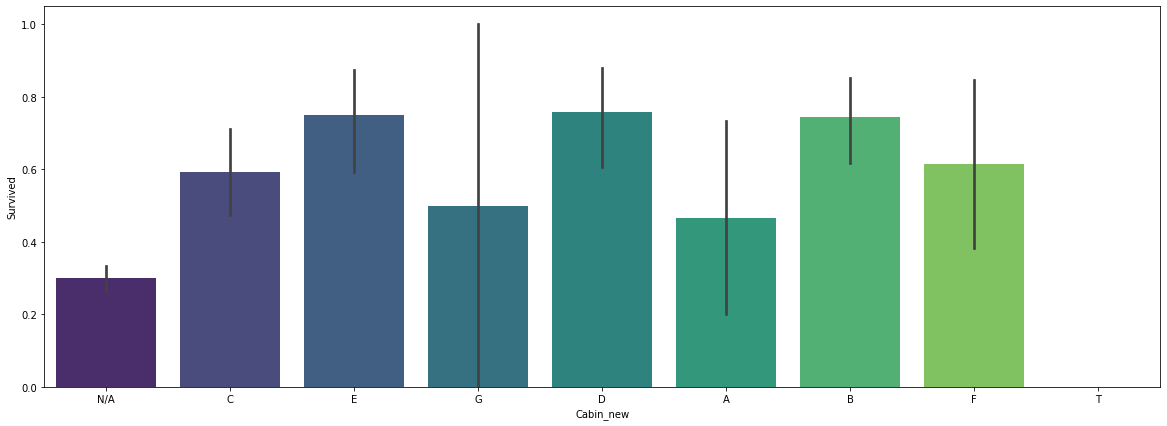

In [24]:
plt.figure(figsize=(20, 7))
sns.barplot(data=train_data, x='Cabin_new', y='Survived', palette="viridis")
plt.show()

**train_data['Embarked']**

In [25]:
print(train_data['Embarked'].unique())

['S' 'C' 'Q' nan]


In [26]:
train_data['Embarked_S'] = train_data['Embarked'].replace({'S':1, 'Q':0, 'C':0})
train_data['Embarked_Q'] = train_data['Embarked'].replace({'S':0, 'Q':1, 'C':0})
train_data['Embarked_C'] = train_data['Embarked'].replace({'S':0, 'Q':0, 'C':1})

In [27]:
print(train_data['Embarked_S'].groupby(train_data['Survived']).sum())
print(train_data['Embarked_Q'].groupby(train_data['Survived']).sum())
print(train_data['Embarked_C'].groupby(train_data['Survived']).sum())

Survived
0    427.0
1    217.0
Name: Embarked_S, dtype: float64
Survived
0    47.0
1    30.0
Name: Embarked_Q, dtype: float64
Survived
0    75.0
1    93.0
Name: Embarked_C, dtype: float64


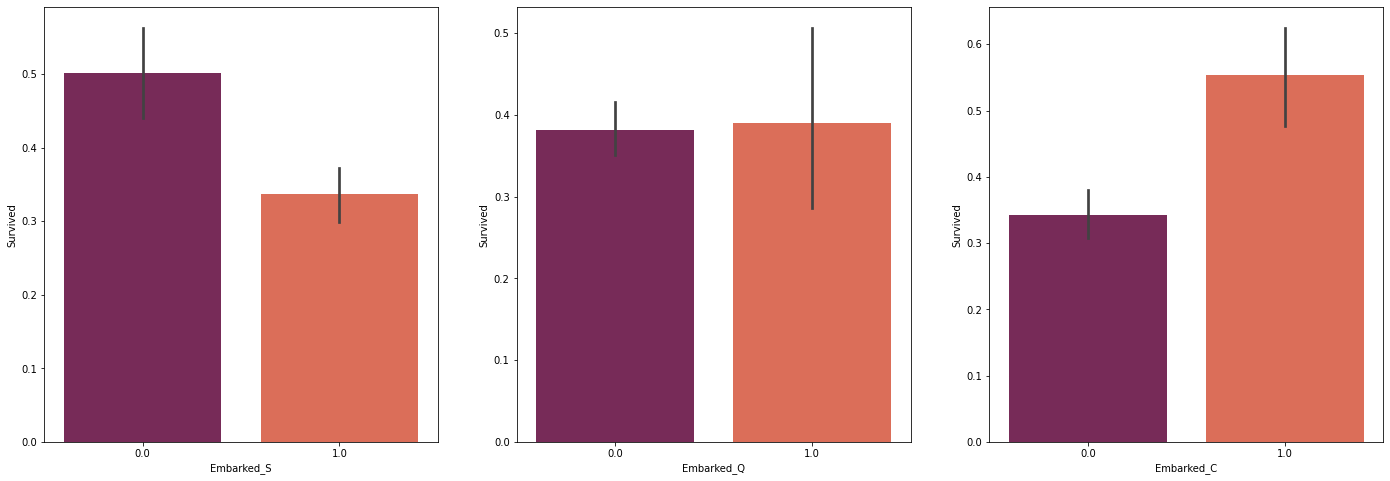

In [28]:
f,(a1,a2,a3) = plt.subplots(1,3,figsize=(24,8),sharex=True)
sns.barplot(x='Embarked_S', y='Survived', data=train_data, palette='rocket', ax=a1)
sns.barplot(x='Embarked_Q', y='Survived', data=train_data, palette='rocket', ax=a2)
sns.barplot(x='Embarked_C', y='Survived', data=train_data, palette='rocket', ax=a3)
plt.show()

# 3 Transforming Test Data

In [29]:
test_data['Pclass_1'] = test_data['Pclass'].replace({1:1, 2:0, 3:0})
test_data['Pclass_2'] = test_data['Pclass'].replace({1:0, 2:1, 3:0})
test_data['Pclass_3'] = test_data['Pclass'].replace({1:0, 2:0, 3:1})



test_data['Title']= test_data.Name.apply(lambda x:x[x.find(','):x.find('.')][1:].strip())
title_list = ['Mr','Mrs','Miss','Ms','Mlle','Lady','Sir','Master']
test_data['Title'] = test_data['Title'].apply(lambda x: 'Mr' if x =='Mr' or x=='Sir' else x)
test_data['Title'] = test_data['Title'].apply(lambda x: 'Mrs' if x =='Mrs' else x)
test_data['Title'] = test_data['Title'].apply(lambda x: 'Miss' if x =='Miss' or x =='Ms' or x=='Mlle' or x=='Lady' else x)
test_data['Title'] = test_data['Title'].apply(lambda x: 'Master' if x =='Master' else x)
test_data['Title'] = test_data['Title'].apply(lambda x: 'Others' if x not in title_list else x)

test_data['Mr'] = (test_data['Title'] == 'Mr').replace(False,0).replace(True,1)
test_data['Mrs'] = (test_data['Title'] == 'Mrs').replace(False,0).replace(True,1)
test_data['Miss'] = (test_data['Title'] == 'Miss').replace(False,0).replace(True,1)
test_data['Others'] = (test_data['Title'] == 'Others').replace(False,0).replace(True,1)
test_data['Master'] = (test_data['Title'] == 'Master').replace(False,0).replace(True,1)


test_data['Male'] = test_data['Sex'].replace({'male':1,'female':0})
test_data['Female'] = test_data['Sex'].replace({'male': 0,'female': 1})


missing_age_values = test_data.groupby('Pclass').median()['Age']
test_data.loc[(test_data['Age'].isnull() == 1) & (test_data['Pclass'] == 1),'Age'] = missing_age_values[1]
test_data.loc[(test_data['Age'].isnull() == 1) & (test_data['Pclass'] == 2),'Age'] = missing_age_values[2]
test_data.loc[(test_data['Age'].isnull() == 1) & (test_data['Pclass'] == 3),'Age'] = missing_age_values[3]

test_data['Age_Senior'] = (test_data['Age']>=60).replace(False,0).replace(True,1)
test_data['Age_LtAdult'] = ((test_data['Age'] >= 45) & (test_data['Age']<60)).replace(False,0).replace(True,1)
test_data['Age_YgAdult'] = ((test_data['Age'] >= 30) & (test_data['Age']<45)).replace(False,0).replace(True,1)
test_data['Age_Teen'] = ((test_data['Age']> 15) & (test_data['Age'] <30)).replace(False,0).replace(True,1)
test_data['Age_Child'] = (test_data['Age'] <=15).replace(False,0).replace(True,1)


test_data['Family'] = test_data['SibSp'] + test_data['Parch'] + 1


test_data['Fare_25%'] = (test_data['Fare']<=8).replace(False,0).replace(True,1)
test_data['Fare_50%'] = ((test_data['Fare']>8)&(test_data['Fare']<=15)).replace(False,0).replace(True,1)
test_data['Fare_75%'] = ((test_data['Fare']>15)&(test_data['Fare']<=30)).replace(False,0).replace(True,1)
test_data['Fare_75%+'] = (test_data['Fare']>31).replace(False,0).replace(True,1)


test_data['Cabin_new']=test_data['Cabin'].astype(str).str[0]
test_data['Cabin_new'] = test_data['Cabin_new'].replace('n','N/A')


test_data['Embarked_S'] = test_data['Embarked'].replace({'S':1, 'Q':0, 'C':0})
test_data['Embarked_Q'] = test_data['Embarked'].replace({'S':0, 'Q':1, 'C':0})
test_data['Embarked_C'] = test_data['Embarked'].replace({'S':0, 'Q':0, 'C':1})

In [30]:
print(test_data.head(10))

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   
5          897       3                    Svensson, Mr. Johan Cervin    male   
6          898       3                          Connolly, Miss. Kate  female   
7          899       2                  Caldwell, Mr. Albert Francis    male   
8          900       3     Abrahim, Mrs. Joseph (Sophie Halaut Easu)  female   
9          901       3                       Davies, Mr. John Samuel    male   

    Age  SibSp  Parch     Ticket     Fare Cabin  ... Age_Child  Family  \
0  34.5      0      0     330911   7.8292   N

# 4 Drop Unused columns and view correlation between columns

In [31]:
print(train_data.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Title', 'Mr', 'Mrs', 'Miss', 'Others', 'Master', 'Male',
       'Female', 'Age_Senior', 'Age_LtAdult', 'Age_YgAdult', 'Age_Teen',
       'Age_Child', 'Family', 'Fare_25%', 'Fare_50%', 'Fare_75%', 'Fare_75%+',
       'Cabin_new', 'Embarked_S', 'Embarked_Q', 'Embarked_C'],
      dtype='object')


In [32]:
drop_columns = ['Pclass', 'Name', 'Sex','Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title']
train_data.drop(drop_columns, axis=1,inplace=True)
test_data.drop(drop_columns, axis=1,inplace=True)

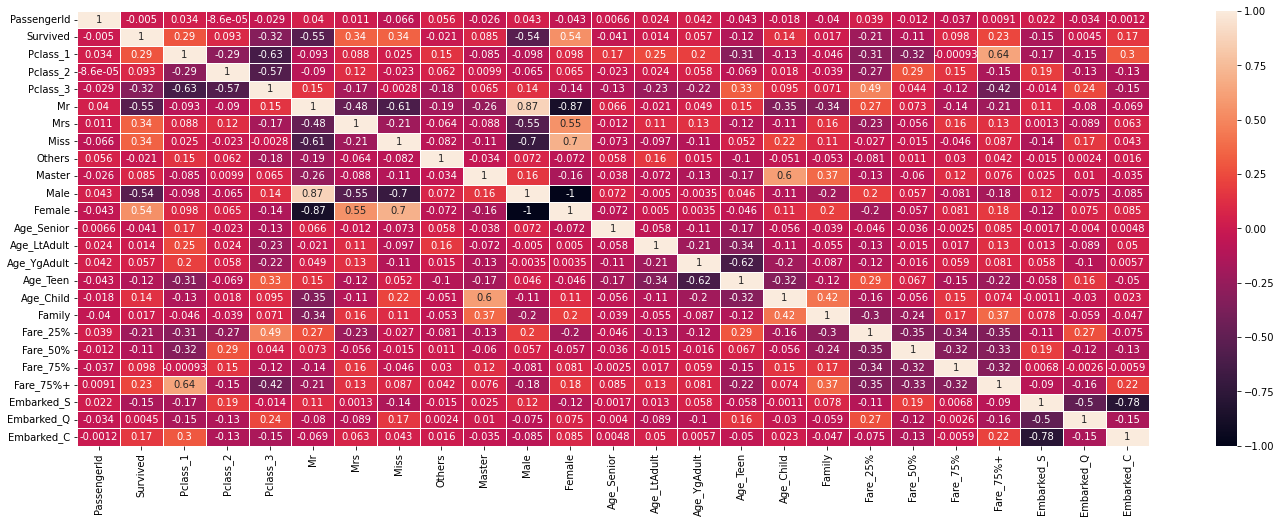

In [33]:
plt.figure(figsize=(24,8))
sns.heatmap(train_data.select_dtypes(include='number').corr(), annot=True, linewidths=0.5)
plt.show()

# 5 Modelling

In [34]:
# drop null values in predicted variable
train_data.dropna(axis=0,subset=['Survived'],inplace=True)
Y = train_data.Survived
train_data.drop(['Survived'],axis=1,inplace=True)

In [35]:
X_train,X_valid,Y_train,Y_valid = train_test_split(train_data, Y, train_size = 0.7, test_size=0.3, random_state=1)

In [36]:
category_cols = [col for col in train_data.columns if X_train[col].dtype == "object"]
numeric_cols = [col for col in train_data.columns if X_train[col].dtype in ['int64', 'float64']]

# print(category_cols)
# print(numeric_cols)

# Pre processing for numerical columns
numeric_transform = SimpleImputer(strategy='mean')


# pre processing for category columns
category_transform = Pipeline(steps = [('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# structuring pipeline for entire preprocessing
preprocessor = ColumnTransformer(transformers=[('num', numeric_transform, numeric_cols), ('cat', category_transform, category_cols)])


In [37]:
# Creating a random forest classifier model in a pipeline

model_RFC = RandomForestClassifier(random_state=100, n_estimators=1000, min_samples_split= 6, min_samples_leaf=2, max_depth=10)

RFC_pipeline = Pipeline(steps=[('preprocess',preprocessor), ('classifier', model_RFC)])

RFC_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['PassengerId', 'Pclass_1',
                                                   'Pclass_2', 'Pclass_3', 'Mr',
                                                   'Mrs', 'Miss', 'Others',
                                                   'Master', 'Male', 'Female',
                                                   'Age_Senior', 'Age_LtAdult',
                                                   'Age_YgAdult', 'Age_Teen',
                                                   'Age_Child', 'Family',
                                                   'Fare_25%', 'Fare_50%',
                                                   'Fare_75%', 'Fare_75%+',
                                                   'Embarked_S', 'Embarked_Q',
                                                   'Embarked_C']),
                                                 ('c

In [38]:
RFC_pred = RFC_pipeline.predict(X_valid)
# print(RFC_pred)

cross_val = cross_val_score(RFC_pipeline, X_train, Y_train, cv=5, scoring='accuracy').mean()
print('Accuracy : ', np.mean(Y_valid == RFC_pred))
print('Cross Validation Score : ', cross_val)

Accuracy :  0.7798507462686567
Cross Validation Score :  0.8491354838709677


In [39]:
RFC_test_pred = RFC_pipeline.predict(test_data)
print(RFC_test_pred)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 0 0 1 0 0 1]


In [40]:
# Update model with Gradient Boost Classifier
model_GBC = GradientBoostingClassifier(random_state=100, n_estimators=200, learning_rate=0.023, max_features=3)

GBC_pipeline = Pipeline(steps=[('preprocess', preprocessor), ('classifier',model_GBC)])

GBC_pipeline.fit(X_train,Y_train)

GBC_pred = GBC_pipeline.predict(X_valid)

cross_val_2 = cross_val_score(GBC_pipeline, X_train, Y_train, cv=5, scoring='accuracy').mean()
print('Accuracy : ', np.mean(Y_valid == GBC_pred))
print('Cross Validation Score : ', cross_val_2)

Accuracy :  0.7798507462686567
Cross Validation Score :  0.8539354838709677


In [41]:
GBC_test_pred = GBC_pipeline.predict(test_data)
print(GBC_test_pred)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 0 0 1 0 0 1]


In [42]:
# np.mean(RFC_test_pred == GBC_test_pred)

# 6 Exporting CSV

In [43]:
output = {'PassengerId':test_data.PassengerId,'Survived':GBC_test_pred}
output_df = pd.DataFrame(data=output)
output_df
output_df.to_csv('model.csv',index=False)